In [1]:
import os
import numpy as np

import tensorflow as tf
import tensorflow_addons as tfa
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
print(tf.__version__)
AUTOTUNE = tf.data.experimental.AUTOTUNE

import deepcell
from deepcell_tracking.utils import Track, load_trks
from sklearn.model_selection import train_test_split
from deepcell.utils.data_utils import reshape_movie
from deepcell.utils.transform_utils import erode_edges
from deepcell.data import split_dataset
from deepcell_toolbox.processing import normalize, histogram_normalization

import spektral

2.5.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [2]:
%%time
path_temp_trks = '/data/3T3_nuc_s0-s2.trks'
all_data = [load_trks(path_temp_trks)]

CPU times: user 566 ms, sys: 1.55 s, total: 2.12 s
Wall time: 26.9 s


In [3]:
%%time
all_tracks = [Track(tracked_data=d) for d in all_data]

CPU times: user 1min 49s, sys: 4.32 s, total: 1min 54s
Wall time: 1min 45s


In [4]:
%%time
from deepcell_tracking.utils import concat_tracks
track_info = concat_tracks(all_tracks)

CPU times: user 1.14 s, sys: 2.05 s, total: 3.19 s
Wall time: 632 ms


In [5]:
for k, v in track_info.items():
    print(k, v.shape)

appearances (11, 71, 168, 32, 32, 1)
centroids (11, 71, 168, 2)
morphologies (11, 71, 168, 3)
adj_matrices (11, 71, 168, 168)
norm_adj_matrices (11, 71, 168, 168)
temporal_adj_matrices (11, 70, 168, 168, 3)


In [6]:
from skimage.exposure import rescale_intensity

def norm(X):
    X_norm = histogram_normalization(X, kernel_size=32)
    
    X_rescaled = np.zeros(X_norm.shape)
    for batch in range(X.shape[0]):
        for frame in range(X.shape[1]):
            x = X[batch, frame]
            x = rescale_intensity(x, out_range=(0,1))
            X_rescaled[batch, frame] = x
            
    return X_rescaled

def prepare_dataset(track_info, batch_size=1, buffer_size=256,
                    seed=None, val_split=0.2):
    
    # Merge tracks along the batch axis
    appearances = track_info['appearances']
    
    app_shape = np.shape(appearances)
    appearances = np.swapaxes(appearances, 1,2) #(0,2,1,3,4,5))
    appearances = np.reshape(appearances, [-1, app_shape[1], app_shape[3], app_shape[4], app_shape[5]])
    
    # Normalize appearances
    appearances = norm(appearances)
    
    input_dict = {'appearances': appearances}
    
    output_dict = {'appearances_decoder': appearances}
    
    dataset = tf.data.Dataset.from_tensor_slices((input_dict, output_dict))
    
    dataset = dataset.shuffle(buffer_size, seed=seed)
    
    # split into train/val
    train_data, val_data, test_data = split_dataset(dataset, val_split)
    
    # batch the data
    train_data = train_data.repeat().batch(batch_size)
    val_data = val_data.repeat().batch(batch_size)
    
    # prefetch the data
    train_data = train_data.prefetch(tf.data.AUTOTUNE)
    val_data = val_data.prefetch(tf.data.AUTOTUNE)
    
    return train_data, val_data

In [7]:
train_data, val_data = prepare_dataset(track_info,
                                       batch_size=1)

In [8]:
it = iter(train_data)

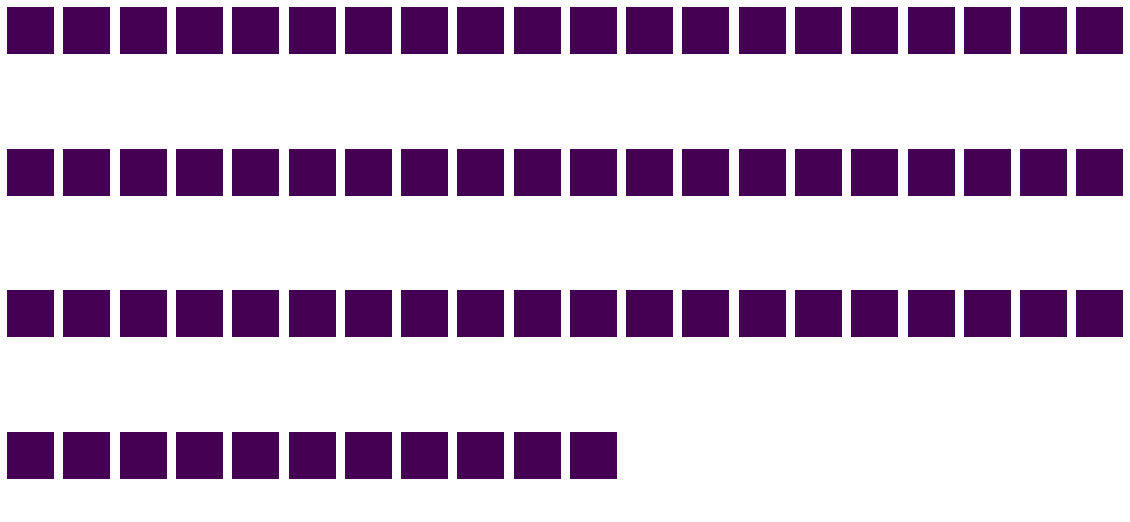

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4,20,figsize=(20,10))

for ax in axes.flatten():
    ax.set_axis_off()
    
nxt = it.next()
for j in range(71):
    axes.flatten()[j].imshow(nxt[0]['appearances'][0,j])
    axes.flatten()[j].set_axis_off()

In [10]:
import numpy as np
import tensorflow as tf

from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, Conv3D, LSTM, Conv2DTranspose
from tensorflow.keras.layers import Input, Concatenate, InputLayer
from tensorflow.keras.layers import Add, Subtract, Dense, Reshape
from tensorflow.keras.layers import MaxPool3D, UpSampling3D
from tensorflow.keras.layers import Activation, Softmax
from tensorflow.keras.layers import BatchNormalization, Lambda
from tensorflow_addons.layers import InstanceNormalization


in_kwargs = {'axis':-1,
             'center': True,
             'scale': True,
             'beta_initializer': 'random_uniform',
             'gamma_initializer': 'random_uniform'}

def residual_block(input_tensor, n_filters=64):
    y = Conv3D(n_filters,
           (1, 3, 3),
           strides=1,
           padding='same')(input_tensor)
    y = InstanceNormalization(**in_kwargs)(y)
    y = Activation('relu')(y)
    
    y = Conv3D(n_filters,
           (1, 3, 3),
           strides=1,
           padding='same')(y)
    y = InstanceNormalization(**in_kwargs)(y)
    y = Activation('relu')(y)
    
    y = Add()([input_tensor, y])
    
    return y
    
class TrajectoryEncoder():   
    def __init__(self,
                 n_filters = 64,
                 encoder_dim=256,
                 embedding_dim=1024,
                 appearance_shape=(71,32,32,1)):
        
        self.n_filters = n_filters
        self.encoder_dim = encoder_dim
        self.embedding_dim = embedding_dim
        self.appearance_shape = appearance_shape
        
        # create encoder
        self.app_encoder = self.get_appearance_encoder()
        
        # create embedding
        self.embedding_model = self.get_embedding_model()
        
        # create decoder
        self.app_decoder = self.get_appearance_decoder()
        
        # create autoencoder
        self.autoencoder = self.get_autoencoder()
    
    def get_appearance_encoder(self):
        app_shape = tuple([None] + list(self.appearance_shape)[1:])
        inputs = Input(shape=app_shape, name='encoder_app_input')

        x = inputs
        x = Conv3D(self.n_filters,
                       (1,3,3),
                       strides=1,
                       padding='same')(x)
        
        for i in range(5): 
            x = residual_block(x, self.n_filters)
            x = residual_block(x, self.n_filters)

            x = Conv3D(self.n_filters, 
                       (1,2,2), 
                       strides=(1,2,2), 
                       padding='valid',
                       use_bias=False)(x)
            
        x = Lambda(lambda t: tf.squeeze(t, axis=(2, 3)))(x)
        x = Dense(self.encoder_dim, name='dense_aeout')(x)
        x = Activation('relu', name='appearance_embedding')(x)
        return Model(inputs=inputs, outputs=x, name='appearance_encoder')
        
    def get_embedding_model(self):
        encoded_shape = tuple([None, self.encoder_dim])
        inputs = Input(shape=encoded_shape, name='embedding_model_input')
        
        x = inputs
        x = Dense(self.embedding_dim)(x)
        x = Activation('relu', name='embedding')(x)
        return Model(inputs=inputs, outputs=x, name='embedding')
    
    def get_appearance_decoder(self):
        embedding_shape = tuple([None, self.embedding_dim])
        inputs = Input(shape=embedding_shape, name='encoder_app_input')

        x = inputs
        x = Lambda(lambda t: tf.expand_dims(t, axis=-2))(x)
        x = Lambda(lambda t: tf.expand_dims(t, axis=-2))(x)
        
        x = Conv3D(self.n_filters,
               (1,3,3),
               strides=1,
               padding='same')(x)
        
        for i in range(5): 
            x = residual_block(x, self.n_filters)
            x = residual_block(x, self.n_filters)
            x = UpSampling3D(size=(1, 2, 2))(x)
            
        x = Dense(1, name='appearance_reconstruction')(x)
        return Model(inputs=inputs, outputs=x, name='appearances_decoder')
        
    def get_autoencoder(self):
        app_input = Input(shape=self.appearance_shape, name='appearances')

        x = self.app_encoder(app_input)
        embedding = self.embedding_model(x)
        reconstruction = self.app_decoder(embedding)

        inputs = app_input
        outputs = [embedding, reconstruction]
        return Model(inputs=inputs, outputs=[embedding, reconstruction])

In [11]:
TE = TrajectoryEncoder()

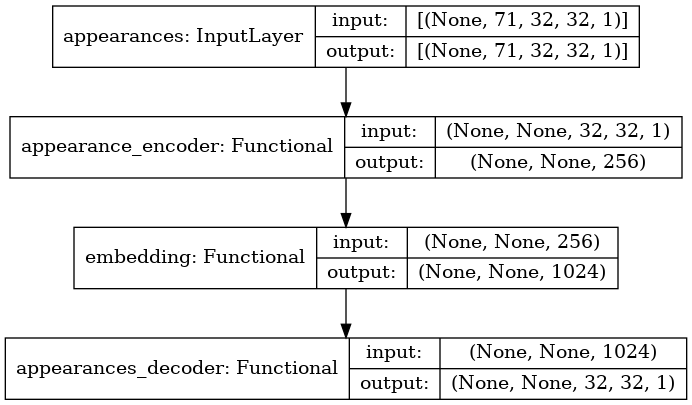

In [12]:
from tensorflow.keras.utils import plot_model
plot_model(TE.autoencoder, show_shapes=True)

In [13]:
def self_supervised_loss(y_true, y_pred):
    
    # Pair the current embedding with the future ground truth
    # so that we predict the future from the past
    
    current_reconstruction = y_pred
    gt = y_true
    
    loss = tf.keras.metrics.mean_squared_error(gt, current_reconstruction)
    
    return loss

In [14]:
from tensorflow_addons.optimizers import RectifiedAdam as RAdam
from deepcell import train_utils

# Define optimizer
optimizer = RAdam(lr=1e-3, clipnorm=0.001)
losses = {'appearances_decoder': self_supervised_loss}
num_gpus = train_utils.count_gpus()
print('Training on {} GPUs'.format(num_gpus))

# Compile model
TE.autoencoder.compile(optimizer=optimizer, loss=losses)

# Train the model
model_path = '/data/models/resize_dense_model'
steps_per_epoch = 2048
validation_steps = 100
n_epochs = 24

train_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        model_path, monitor='val_loss',
        save_best_only=True, verbose=1,
        save_weights_only=False),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, verbose=1,
        patience=3, min_lr=1e-7)
]

loss_history = TE.autoencoder.fit(
    train_data,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_data,
    validation_steps=validation_steps,
    epochs=n_epochs,
    verbose=1,
    callbacks=train_callbacks)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Training on 1 GPUs
Epoch 1/24
2048/2048 [==============================] - 361s 155ms/step - loss: 0.0157 - appearances_decoder_loss: 0.0157 - val_loss: 0.0123 - val_appearances_decoder_loss: 0.0123

Epoch 00001: val_loss improved from inf to 0.01234, saving model to /data/models/resize_dense_model


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /data/models/resize_dense_model/assets


INFO:tensorflow:Assets written to: /data/models/resize_dense_model/assets


Epoch 2/24
2048/2048 [==============================] - 316s 154ms/step - loss: 0.0072 - appearances_decoder_loss: 0.0072 - val_loss: 0.0098 - val_appearances_decoder_loss: 0.0098

Epoch 00002: val_loss improved from 0.01234 to 0.00977, saving model to /data/models/resize_dense_model


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /data/models/resize_dense_model/assets


INFO:tensorflow:Assets written to: /data/models/resize_dense_model/assets


Epoch 3/24
2048/2048 [==============================] - 316s 154ms/step - loss: 0.0063 - appearances_decoder_loss: 0.0063 - val_loss: 0.0061 - val_appearances_decoder_loss: 0.0061

Epoch 00003: val_loss improved from 0.00977 to 0.00611, saving model to /data/models/resize_dense_model


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /data/models/resize_dense_model/assets


INFO:tensorflow:Assets written to: /data/models/resize_dense_model/assets


Epoch 4/24
2048/2048 [==============================] - 316s 154ms/step - loss: 0.0050 - appearances_decoder_loss: 0.0050 - val_loss: 0.0071 - val_appearances_decoder_loss: 0.0071

Epoch 00004: val_loss did not improve from 0.00611
Epoch 5/24
2048/2048 [==============================] - 315s 154ms/step - loss: 0.0046 - appearances_decoder_loss: 0.0046 - val_loss: 0.0055 - val_appearances_decoder_loss: 0.0055

Epoch 00005: val_loss improved from 0.00611 to 0.00552, saving model to /data/models/resize_dense_model


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /data/models/resize_dense_model/assets


INFO:tensorflow:Assets written to: /data/models/resize_dense_model/assets


Epoch 6/24
2048/2048 [==============================] - 315s 154ms/step - loss: 0.0044 - appearances_decoder_loss: 0.0044 - val_loss: 0.0049 - val_appearances_decoder_loss: 0.0049

Epoch 00006: val_loss improved from 0.00552 to 0.00488, saving model to /data/models/resize_dense_model


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /data/models/resize_dense_model/assets


INFO:tensorflow:Assets written to: /data/models/resize_dense_model/assets


Epoch 7/24
2048/2048 [==============================] - 316s 154ms/step - loss: 0.0037 - appearances_decoder_loss: 0.0037 - val_loss: 0.0068 - val_appearances_decoder_loss: 0.0068

Epoch 00007: val_loss did not improve from 0.00488
Epoch 8/24
2048/2048 [==============================] - 317s 155ms/step - loss: 0.0037 - appearances_decoder_loss: 0.0037 - val_loss: 0.0042 - val_appearances_decoder_loss: 0.0042

Epoch 00008: val_loss improved from 0.00488 to 0.00424, saving model to /data/models/resize_dense_model


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /data/models/resize_dense_model/assets


INFO:tensorflow:Assets written to: /data/models/resize_dense_model/assets


Epoch 9/24
2048/2048 [==============================] - 315s 154ms/step - loss: 0.0032 - appearances_decoder_loss: 0.0032 - val_loss: 0.0049 - val_appearances_decoder_loss: 0.0049

Epoch 00009: val_loss did not improve from 0.00424
Epoch 10/24
1464/2048 [====================>.........] - ETA: 1:28 - loss: 0.0031 - appearances_decoder_loss: 0.0031

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2048/2048 [==============================] - 316s 154ms/step - loss: 0.0030 - appearances_decoder_loss: 0.0030 - val_loss: 0.0041 - val_appearances_decoder_loss: 0.0041

Epoch 00011: val_loss improved from 0.00424 to 0.00407, saving model to /data/models/resize_dense_model


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /data/models/resize_dense_model/assets


INFO:tensorflow:Assets written to: /data/models/resize_dense_model/assets


Epoch 12/24
2048/2048 [==============================] - 315s 154ms/step - loss: 0.0027 - appearances_decoder_loss: 0.0027 - val_loss: 0.0037 - val_appearances_decoder_loss: 0.0037

Epoch 00012: val_loss improved from 0.00407 to 0.00368, saving model to /data/models/resize_dense_model


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /data/models/resize_dense_model/assets


INFO:tensorflow:Assets written to: /data/models/resize_dense_model/assets


Epoch 13/24
1286/2048 [=================>............] - ETA: 1:55 - loss: 0.0029 - appearances_decoder_loss: 0.0029

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2048/2048 [==============================] - 317s 155ms/step - loss: 0.0025 - appearances_decoder_loss: 0.0025 - val_loss: 0.0037 - val_appearances_decoder_loss: 0.0037

Epoch 00014: val_loss did not improve from 0.00344
Epoch 15/24
2048/2048 [==============================] - 317s 155ms/step - loss: 0.0027 - appearances_decoder_loss: 0.0027 - val_loss: 0.0033 - val_appearances_decoder_loss: 0.0033

Epoch 00015: val_loss improved from 0.00344 to 0.00330, saving model to /data/models/resize_dense_model


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /data/models/resize_dense_model/assets


INFO:tensorflow:Assets written to: /data/models/resize_dense_model/assets


Epoch 16/24
2048/2048 [==============================] - 316s 154ms/step - loss: 0.0026 - appearances_decoder_loss: 0.0026 - val_loss: 0.0038 - val_appearances_decoder_loss: 0.0038

Epoch 00016: val_loss did not improve from 0.00330
Epoch 17/24
2048/2048 [==============================] - 316s 154ms/step - loss: 0.0024 - appearances_decoder_loss: 0.0024 - val_loss: 0.0034 - val_appearances_decoder_loss: 0.0034

Epoch 00017: val_loss did not improve from 0.00330
Epoch 18/24
 291/2048 [===>..........................] - ETA: 4:26 - loss: 0.0034 - appearances_decoder_loss: 0.0034

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2048/2048 [==============================] - 314s 154ms/step - loss: 0.0019 - appearances_decoder_loss: 0.0019 - val_loss: 0.0031 - val_appearances_decoder_loss: 0.0031

Epoch 00019: val_loss improved from 0.00324 to 0.00305, saving model to /data/models/resize_dense_model


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /data/models/resize_dense_model/assets


INFO:tensorflow:Assets written to: /data/models/resize_dense_model/assets


Epoch 20/24
2048/2048 [==============================] - 314s 153ms/step - loss: 0.0020 - appearances_decoder_loss: 0.0020 - val_loss: 0.0024 - val_appearances_decoder_loss: 0.0024

Epoch 00020: val_loss improved from 0.00305 to 0.00239, saving model to /data/models/resize_dense_model


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /data/models/resize_dense_model/assets


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2048/2048 [==============================] - 315s 154ms/step - loss: 0.0019 - appearances_decoder_loss: 0.0019 - val_loss: 0.0026 - val_appearances_decoder_loss: 0.0026

Epoch 00023: val_loss did not improve from 0.00237

Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 24/24
1611/2048 [======================>.......] - ETA: 1:06 - loss: 0.0016 - appearances_decoder_loss: 0.0016

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [15]:
TE.app_encoder.save('/data/models/resize_dense_app_encoder')
TE.embedding_model.save('/data/models/resize_dense_embedding_model')
TE.app_decoder.save('/data/models/resize_dense_app_decoder')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /data/models/resize_dense_app_encoder/assets


INFO:tensorflow:Assets written to: /data/models/resize_dense_app_encoder/assets


INFO:tensorflow:Assets written to: /data/models/resize_dense_embedding_model/assets


INFO:tensorflow:Assets written to: /data/models/resize_dense_embedding_model/assets


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /data/models/resize_dense_app_decoder/assets


INFO:tensorflow:Assets written to: /data/models/resize_dense_app_decoder/assets


In [16]:
it = iter(train_data)

In [17]:
nxt = it.next()
inputs = nxt[0]['appearances']

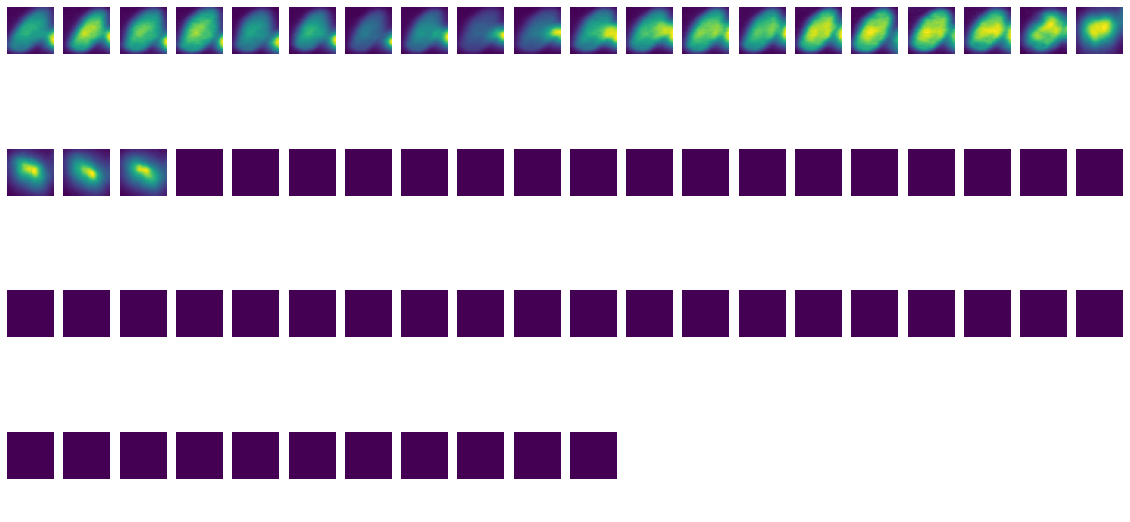

In [18]:
fig, axes = plt.subplots(4,20,figsize=(20,10))

for ax in axes.flatten():
    ax.set_axis_off()
    
for j in range(71):
    axes.flatten()[j].imshow(inputs[0,j])
    axes.flatten()[j].set_axis_off()

In [19]:
app_encoded = TE.app_encoder(inputs)
embedding = TE.embedding_model(app_encoded)
reconstruction = TE.app_decoder(embedding)

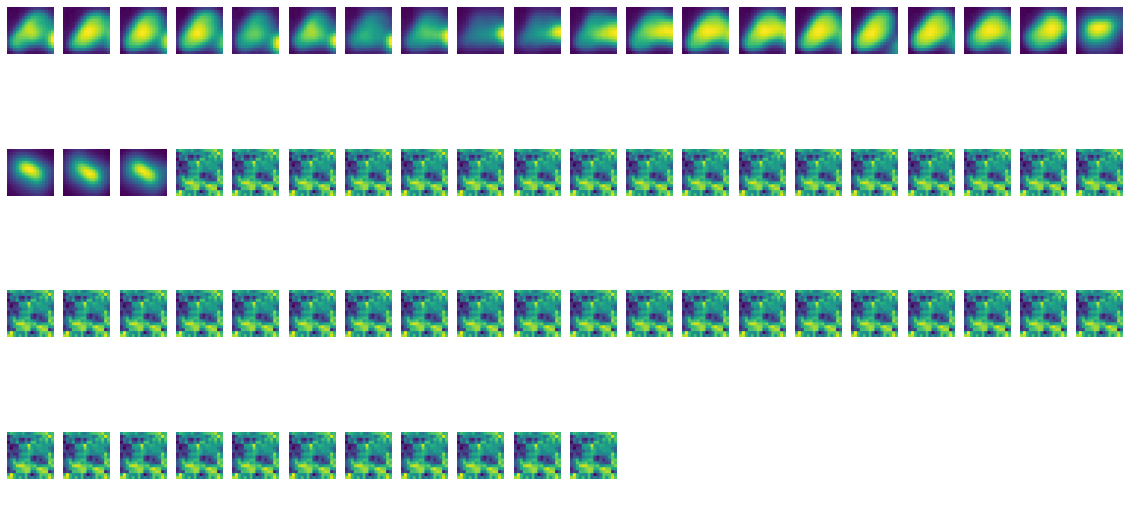

In [20]:
fig, axes = plt.subplots(4,20,figsize=(20,10))

for ax in axes.flatten():
    ax.set_axis_off()
    
for j in range(71):
    axes.flatten()[j].imshow(reconstruction[0,j])
    axes.flatten()[j].set_axis_off()

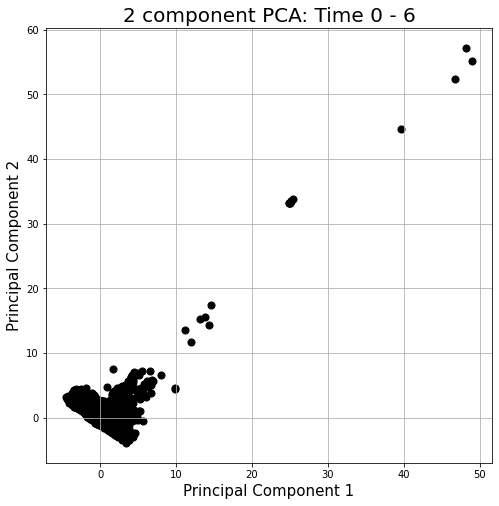

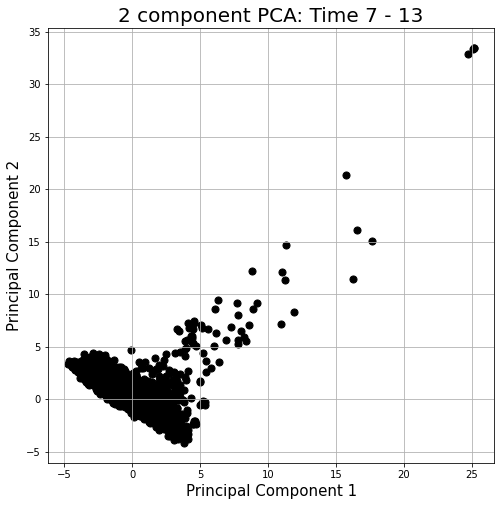

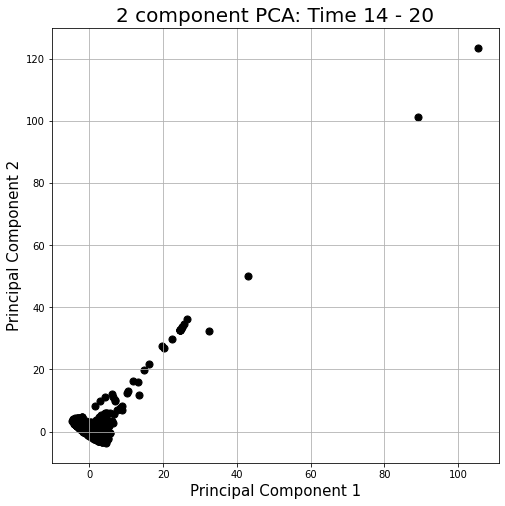

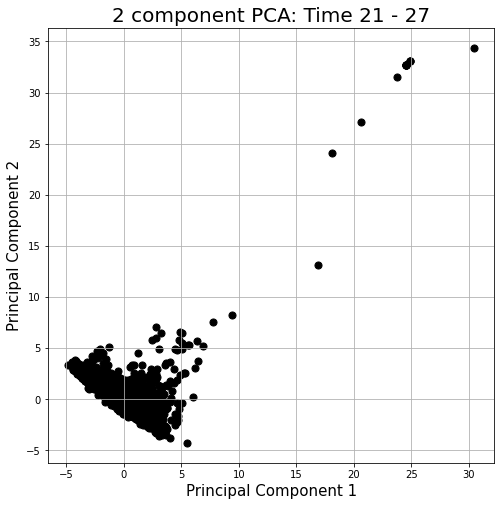

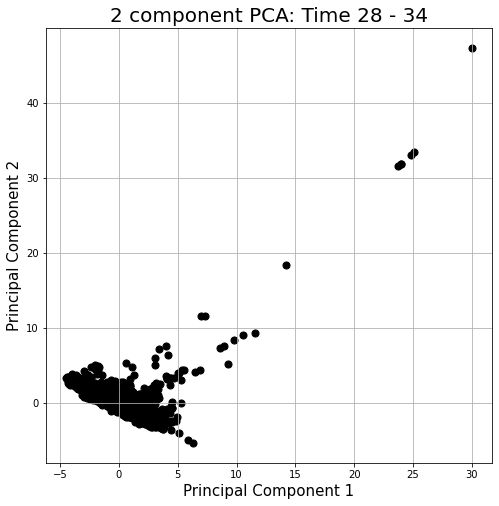

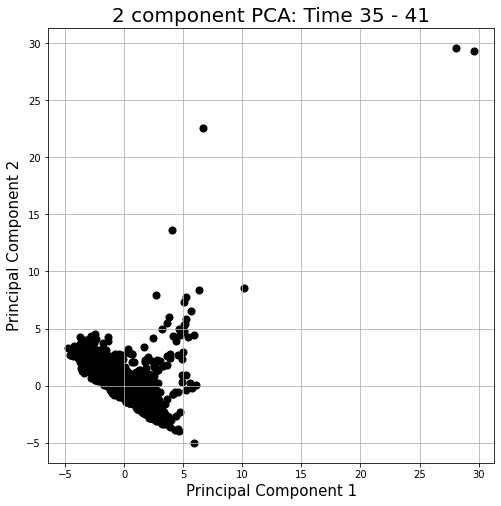

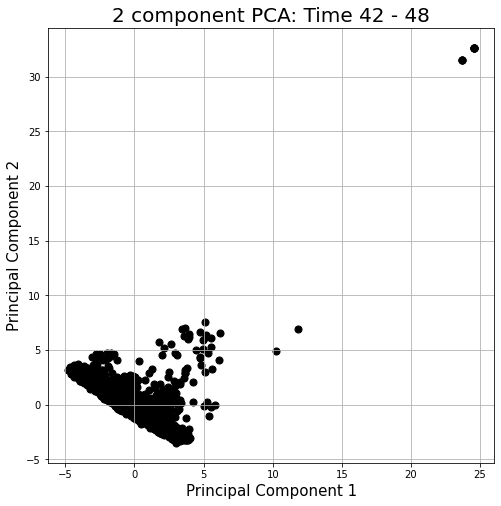

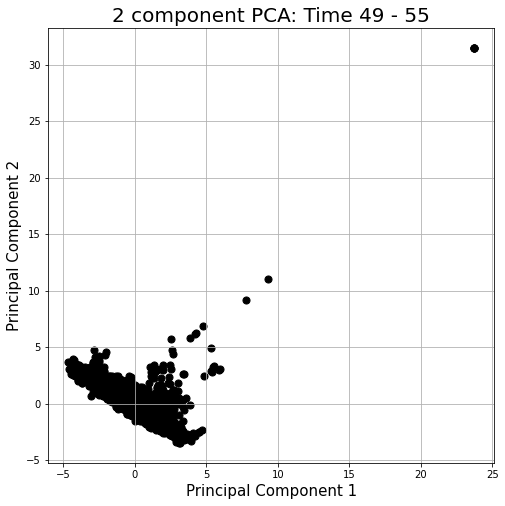

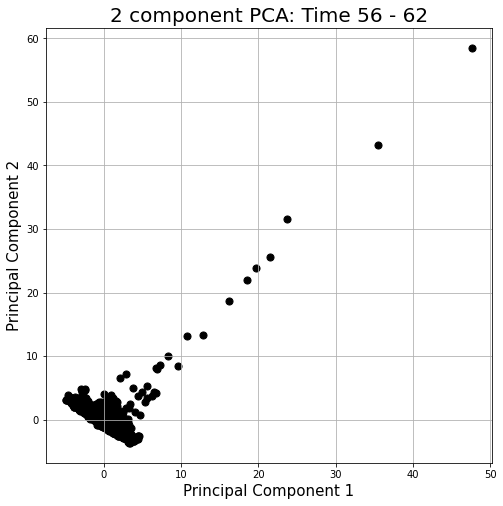

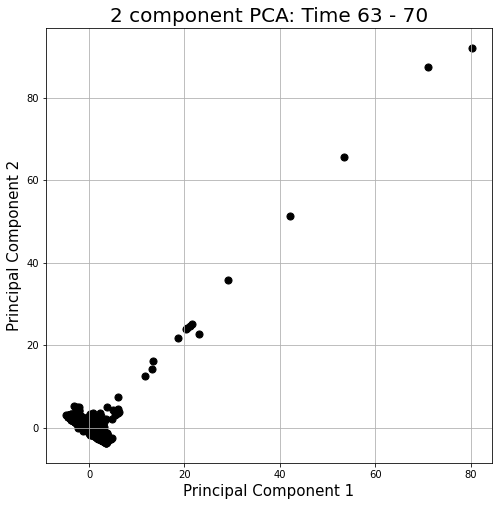

In [21]:
import pandas as pd

def get_temp_embeddings_df():
    # Get data to feed forward through encoder in order of track_info['appearances']
    # Merge tracks along the batch axis
    appearances = track_info['appearances']

    app_shape = np.shape(appearances)
    appearances = np.swapaxes(appearances, 1,2) #(0,2,1,3,4,5))
    appearances = np.reshape(appearances, [-1, app_shape[1], app_shape[3], app_shape[4], app_shape[5]])

    # Normalize appearances
    appearances = norm(appearances)

    input_dict = {'appearances': appearances}

    output_dict = {'appearances_decoder': appearances}

    data = tf.data.Dataset.from_tensor_slices((input_dict, output_dict))

    data = data.repeat().batch(1)
    
    it = iter(data)

    shape = track_info['appearances'].shape
    # number of batches * number of cells per batch
    num_cells = shape[0] * shape[2]

    temp_embeddings_lst = []

    for cell in range(num_cells):
        batch = cell // shape[2]
        pos = cell - shape[2] * (cell // shape[2])
        first_frame = -1
        last_frame = -1
        centroids_shape = track_info['centroids'].shape
        for frame in range(centroids_shape[1]):
            if not np.array_equal(track_info['centroids'][batch][frame][pos], np.zeros(2, dtype='float32')):
                first_frame = frame
                break
        for frame in range(centroids_shape[1] - 1, -1, -1):
            if not np.array_equal(track_info['centroids'][batch][frame][pos], np.zeros(2, dtype='float32')):
                last_frame = frame
                break
        
        nxt = it.next()
        if first_frame != -1:
            inputs = nxt[0]['appearances']
            app_encoded = TE.app_encoder(inputs)
            embeddings = TE.embedding_model(app_encoded)
            for frame in range(first_frame, last_frame + 1):
                # append time number to embedding
                time = frame - first_frame
                temp_embeddings_lst.append(np.append(embeddings[0][frame].numpy().astype('float32'), time))
            
    cols = [idx for idx in range(TE.embedding_dim)]
    cols.append('Time')
    temp_embeddings_df = pd.DataFrame(temp_embeddings_lst, columns=cols)
    
    return temp_embeddings_df

from sklearn.preprocessing import StandardScaler

def standardize_embeddings(temp_embeddings_df):
    features = [idx for idx in range(TE.embedding_dim)]
    embeddings = temp_embeddings_df.loc[:, features].values
    std_embeddings = StandardScaler().fit_transform(embeddings)
    
    std_embeddings_df = pd.DataFrame(std_embeddings)
    
    return std_embeddings_df

from sklearn.decomposition import PCA
pca = PCA(n_components=2)

def project_embeddings(temp_embeddings_df):
    std_embeddings_df = standardize_embeddings(temp_embeddings_df)
    
    principal_components = pca.fit_transform(std_embeddings_df)
    principal_df = pd.DataFrame(data = principal_components, columns = ['component 1', 'component 2'])
    
    final_df = pd.concat([principal_df, temp_embeddings_df[['Time']]], axis = 1)
                          
    return final_df

temp_embeddings_df = get_temp_embeddings_df()
temp_embeddings_pca_df = project_embeddings(temp_embeddings_df)

import math

shape = track_info['appearances'].shape

for time_sect in range(10):
    time_init = math.floor(shape[1] * time_sect / 10)
    time_final = math.floor(shape[1] * (time_sect + 1) / 10) - 1
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA: Time ' + str(time_init) + ' - ' + str(time_final), fontsize = 20)
    times = [time for time in range(time_init, time_final + 1)]
    for time in times:
        indices_to_keep = (temp_embeddings_pca_df['Time'] == time)
        ax.scatter(temp_embeddings_pca_df.loc[indices_to_keep, 'component 1'], temp_embeddings_pca_df.loc[indices_to_keep, 'component 2'], c = 'black', s = 50)
    ax.grid()
    plt.savefig('embedding_graphs/resize_dense_embeddings_pca/resize_dense_embeddings_pca_' + str(time_init) + '_' + str(time_final) + '.jpg')

In [22]:
pca.explained_variance_ratio_

array([0.04847861, 0.04688752])

In [23]:
cols = [idx for idx in range(TE.embedding_dim)]
cols.append('Frame')
temp_embeddings_df.to_csv('/data/large_files/embeddings/resize_dense_embeddings.csv', header=cols)

In [24]:
cols = ['component 1', 'component 2', 'Frame']
temp_embeddings_pca_df.to_csv('/data/large_files/embeddings/resize_dense_embeddings_pca.csv', header=cols)